In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
MODEL_NAME = 'DCGAN'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
TARGET_IMG_SIZE = 64 # Scale images to this size

BATCH_SIZE = 128
NOISE_DIM = 100
LAMBDA = 10 # For gradient penalty

EPOCHs = 40
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every n epoch

N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [3]:
# Modify the directory to the path of your dataset
list_ds = tf.data.Dataset.list_files('/kaggle/input/img-align-celeba/t/celebA/*.png')

for f in list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/img-align-celeba/t/celebA/003652.png'
b'/kaggle/input/img-align-celeba/t/celebA/005031.png'
b'/kaggle/input/img-align-celeba/t/celebA/015912.png'
b'/kaggle/input/img-align-celeba/t/celebA/016469.png'
b'/kaggle/input/img-align-celeba/t/celebA/024073.png'


In [4]:
def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE),
                           method='bicubic', antialias=True)
    images = normalize(images)
    return images

In [5]:
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)

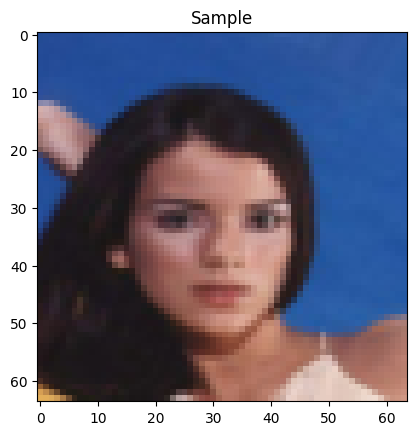

In [6]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1))

In [7]:
# You could also try layer normalization instead of batch normalization

def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(shape=input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

In [8]:
def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [9]:
generator = CGAN_generator((100,))

In [10]:
generator.summary()
# Require extra packages to plot model 
# plot_model(generator, show_shapes=True, dpi=64)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │       4,194,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,772,928 (29.65 MB)

 Trainable params: 7,771,008 (29.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
discriminator = CGAN_discriminator()

In [12]:
discriminator.summary()
# Require extra packages to plot model 
# plot_model(discriminator, show_shapes=True, dpi=64)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,793 (10.54 MB)

 Trainable params: 2,763,793 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [14]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [15]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


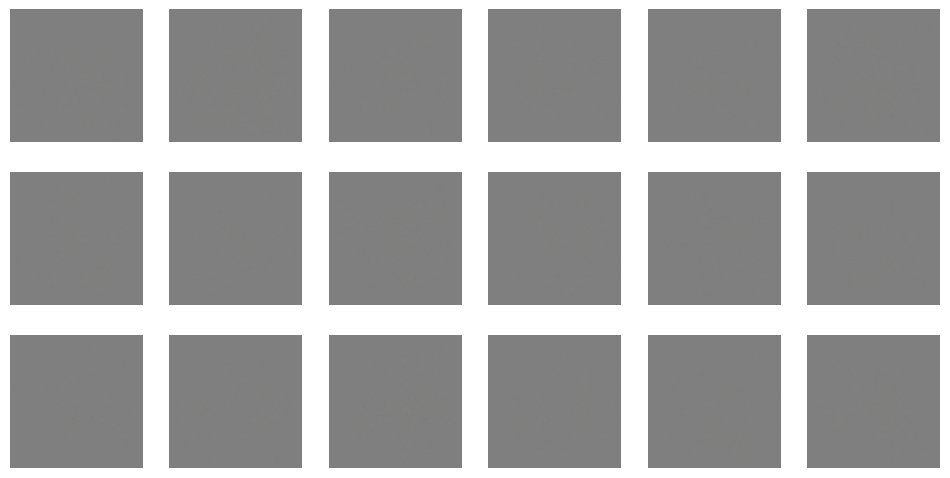

In [16]:
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

In [17]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

In [18]:
@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


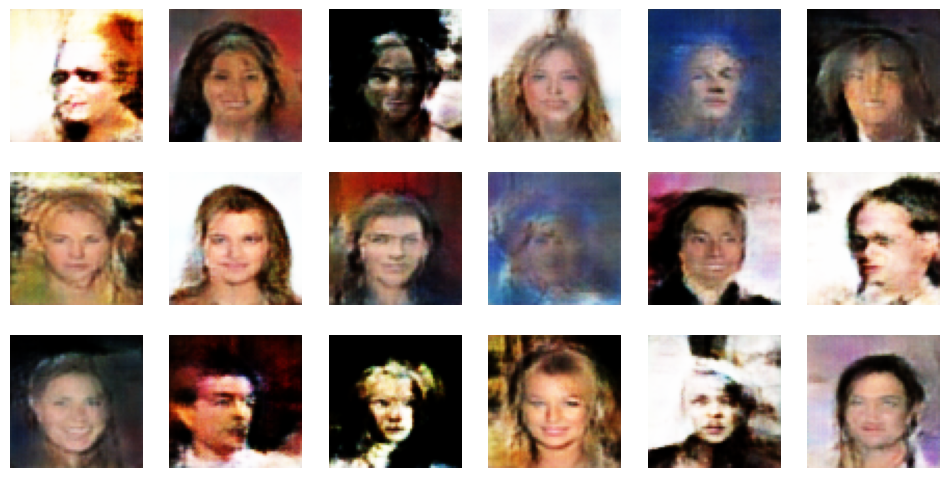

Saving checkpoint for epoch 60 at checkpoints/tensorflow/DCGAN/ckpt-4
Time taken for epoch 60 is 49.930898666381836 sec

Saving checkpoint for epoch 60 at checkpoints/tensorflow/DCGAN/ckpt-5


In [21]:
# Set the total number of epochs dynamically
EPOCHs = int(input("Enter the total number of epochs you want to train: "))
initial_learning_rate = 0.0002  # Set your desired initial learning rate
current_learning_rate = initial_learning_rate 
n_critic_count = 0  # Initialize the critic counter
N_CRITIC = 5
for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    
    # Apply learning rate decay
    current_learning_rate = float(learning_rate_decay(current_learning_rate))  # Ensure float
    print('current_learning_rate: %f' % current_learning_rate)
    print('Type of current_learning_rate:', type(current_learning_rate))  # Debugging check
    
    # Update optimizers' learning rates
    try:
        # Use .assign() for learning rate updates
        D_optimizer.learning_rate.assign(current_learning_rate)
        G_optimizer.learning_rate.assign(current_learning_rate)
    except AttributeError as e:
        print("Error in setting learning rate:", e)
        print("Learning rate value:", current_learning_rate)
        print("Type of learning rate value:", type(current_learning_rate))
        raise
    
    for step, (image) in enumerate(train_data):
        current_batch_size = image.shape[0]
        WGAN_GP_train_d_step(
            image,
            batch_size=tf.constant(current_batch_size, dtype=tf.int64),
            step=tf.constant(step, dtype=tf.int64)
        )
        n_critic_count += 1
        if n_critic_count >= N_CRITIC:
            WGAN_GP_train_g_step(
                image,
                batch_size=tf.constant(current_batch_size, dtype=tf.int64),
                step=tf.constant(step, dtype=tf.int64)
            )
            n_critic_count = 0
        
        if step % 10 == 0:
            print('.', end='')
    
    clear_output(wait=True)
    generate_and_save_images(
        generator,
        epoch,
        [sample_noise],
        figure_size=(12, 6),
        subplot=(3, 6),
        save=True,
        is_flatten=False
    )
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))
    
    print('Time taken for epoch {} is {} sec\n'.format(epoch, time.time() - start))

# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print('Saving checkpoint for epoch {} at {}'.format(EPOCHs, ckpt_save_path))


In [22]:
# Use new sample to see the performance of the model.
test_noise = tf.random.normal([64, NOISE_DIM])
prediction = generator.predict(test_noise)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [23]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))

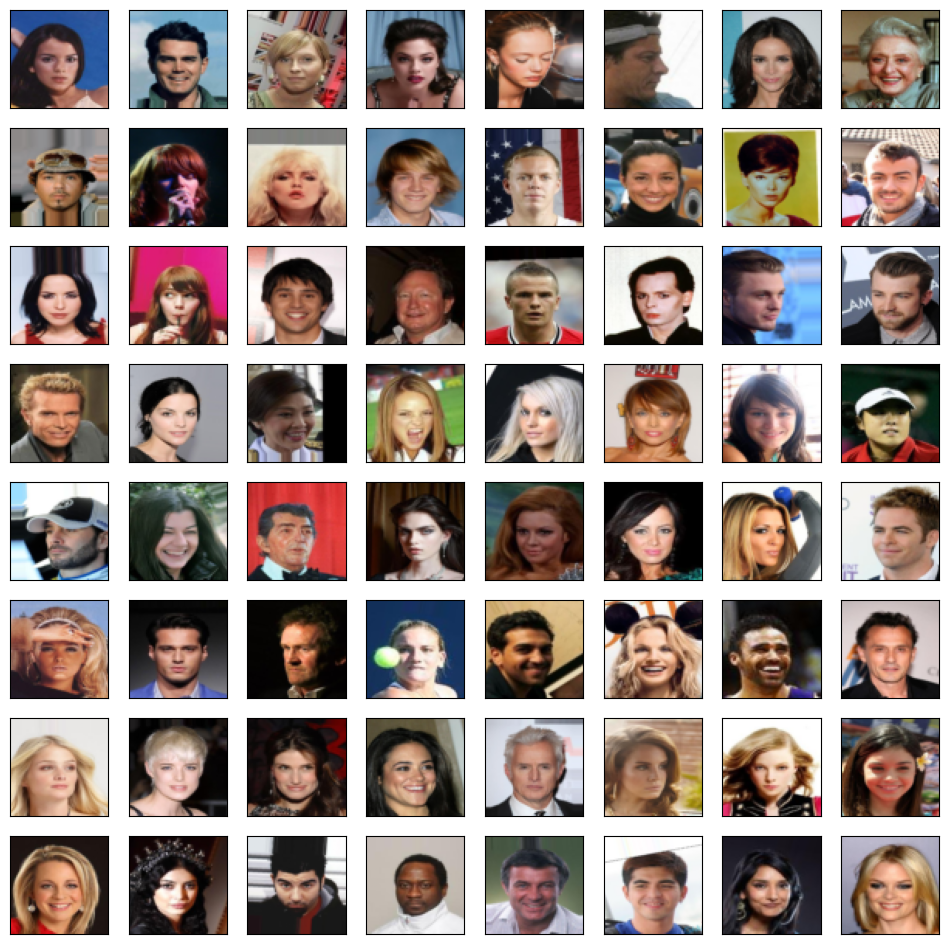

In [24]:
# Plot the real images for dataset
fig1 = plt.figure(figsize=(12,12))
image_grid(sample_img.numpy()[:64], fig1)
plt.show()

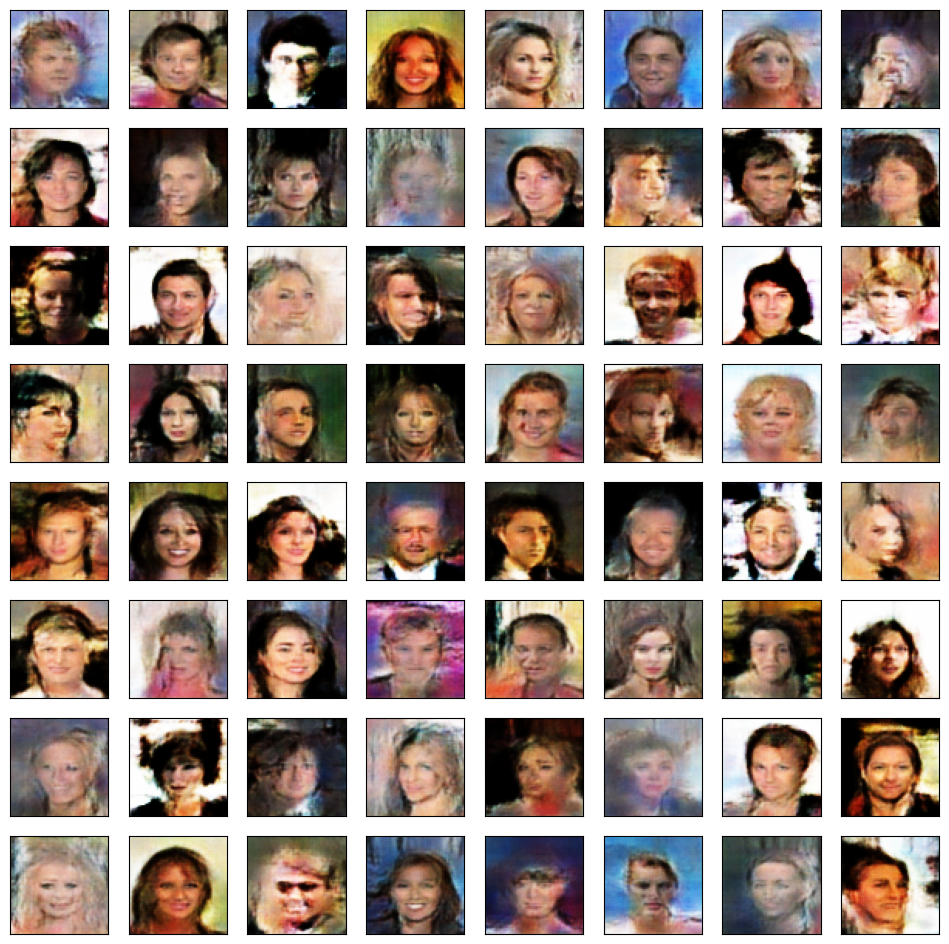

In [25]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)